# Online Shoppers Purchasing Intention Prediction

## Импорт библиотек и загрузка данных

In [ ]:
!pip install scikit-plot

In [ ]:
!pip install imblearn

In [ ]:
!pip install explainerdashboard==0.4.3 -q

In [23]:
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as splt
import IPython.display as display

from explainerdashboard import ClassifierExplainer, ExplainerDashboard
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV, RandomizedSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import roc_auc_score, roc_curve, auc, confusion_matrix, matthews_corrcoef
from imblearn.metrics import sensitivity_score, specificity_score, geometric_mean_score

from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, RobustScaler
from sklearn.compose import ColumnTransformer

%matplotlib inline

sns.set(style='darkgrid')
plt.rcParams['figure.figsize'] = (5,3)

В проекте используются данные об активности онлайн-покупателей на сайте магазина.

[Оригинальный датасет](https://archive.ics.uci.edu/ml/datasets/Online+Shoppers+Purchasing+Intention+Dataset). *Sakar,C. and Kastro,Yomi. (2018). Online Shoppers Purchasing Intention Dataset. UCI Machine Learning Repository. https://doi.org/10.24432/C5F88Q.*



На данном этапе мы работаем с датасетом, полученным после проведения разведочного анализа. В ходе предобработки были сделаны следующие изменения:

- удаление дублирующихся строк;

- исключение строк с пропущенными значениями в столбце ```ExitRates```;

- замена пропущенных значений в стоблцах ```Informational_Duration``` и ```ProductRelated_Duration``` на медианные значения этих признаков;

- удаление строк, где количество просмотренных *ProductRelated* страниц равно нулю, а значение показателя *ProductRelated_Duration* больше нуля (такие наблюдения считаются нелогичными);

- приведение строковых значений категориального признака *Month* к единообразному формату.

In [74]:
SHOPPERS_DATASET = 'https://raw.githubusercontent.com/ErmakovaAna/shoppers-intention-prediction/main/EDA/shoppers_preprocessed.csv'

In [75]:
df = pd.read_csv(SHOPPERS_DATASET)

## Описание данныx

Предобработанный датасет содержит **12117 объектов**, каждый из которых представляет собой описание сессии покупателя на сайте онлайн магазина.

Каждому объекту соответствует **18 атрибутов**, включая целевую переменную `Revenue`, которая указывает на факт совершения покупки (*True* — сессия завершилась покупкой, *False* — покупатель покинул сайт, ничего не купив).

In [26]:
df.shape

(12117, 18)

In [27]:
df.sample(5)

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
8420,6,368.750,0,0.0,46,3368.305556,0.003846,0.011859,0.0,0.0,Nov,2,2,1,2,New_Visitor,False,0
9294,4,23.375,2,231.6,35,996.148077,0.006081,0.041742,0.0,0.0,Nov,2,2,5,2,Returning_Visitor,True,0
1500,0,0.000,0,0.0,19,926.633333,0.011111,0.029630,0.0,0.0,Mar,2,2,2,1,Returning_Visitor,True,0
1224,1,42.000,2,80.5,46,838.683333,0.000000,0.015417,0.0,0.0,Mar,2,2,1,10,Returning_Visitor,False,0
8689,0,0.000,0,0.0,10,664.500000,0.000000,0.040000,0.0,0.0,Nov,2,2,8,2,New_Visitor,True,0


В датасете представлены ***10 числовых*** признаков:

|                         | description                                                                           |         mean |       median |          std |   min |       max |
|:------------------------|:--------------------------------------------------------------------------------------|-------------:|-------------:|-------------:|------:|----------:|
| **Administrative**          | количество *administrative* страниц, которое посетил пользователь во время сессии                                 |    2.33582   |   1          |    3.32933   |     0 |    27     |
| **Informational**           | количество *informational* страниц, которое посетил пользователь во время сессии                                   |    0.50806   |   0          |    1.27491   |     0 |    24     |
| **ProductRelated**         | количество *product related* страниц, которое посетил пользователь во время сессии                                 |   32.0051    |  18          |   44.5785    |     0 |   705     |
| **Administrative_Duration** |количество времени, проведенное на *administrative* страницах                                                    |   81.5394    |   9          |  177.4       |     0 |  3398.75  |
| **Informational_Duration**  | количество времени, проведенное на *informational* страницах                                                     |   34.4688    |   0          |  141.164     |     0 |  2549.38  |
| **ProductRelated_Duration** | количество времени, проведенное на *product related* страницах                                                   | 1177.58      | 606.283      | 1878.67      |     0 | 63973.5   |
| **BounceRates**             | процент сессий, во время которых была просмотрена *только* определенная страница, от общего количества сессий, начавшихся с просмотра этой страницы |    0.0206055 |   0.00294118 |    0.0456899 |     0 |     0.2   |
| **ExitRates**               | процент сессий, которые заканчиваются просмотром данной страницы                      |    0.0416095 |   0.025      |    0.0464317 |     0 |     0.2   |
| **PageValues**              | средняя ценность страниц, рассчитываемая путем деления общего дохода на количество сессий, в рамках которых посещалась данные страницы                                                                                   |    5.94178   |   0          |   18.6427    |     0 |   361.764 |
| **SpecialDay**              |показатель близости времени посещения сайта к некоторому праздничному дню                                          |    0.0618607 |   0          |    0.199548  |     0 |     1     |

и ***8 категориальных*** признаков, в том числе выраженных целочисленными, строковыми и булевыми значениями:

|                  | description                               |   unique |   top |   freq |
|:-----------------|:------------------------------------------|---------:|------:|-------:|
| **OperatingSystems** | операционная система пользователя         |        8 |     2 |   6547 |
| **Browser**          | браузер, через который выполнялась сессия |       13 |     2 |   7890 |
| **Region**           | регион пользователя                       |        9 |     1 |   4722 |
| **TrafficType**      | категория трафика                         |       20 |     2 |   3912 |
| **Month**       | месяц выполнения сессии |       11 | May               |   3316 |
| **VisitorType** | категория пользователя  |        3 | Returning_Visitor |  10446 |
| **Weekend** | флаг, указывающий на то, выполнялась ли сессия на выходных                |        2 |     False |   9360 |
| **Revenue** | флаг, указывающий на то, была ли завершена покупка в рамках данной сессии |        2 |     False |  10313 |

In [28]:
df.OperatingSystems = df.OperatingSystems.astype(object)
df.Browser = df.Browser.astype(object)
df.Region = df.Region.astype(object)
df.TrafficType = df.TrafficType.astype(object)

In [29]:
numerical = ['Administrative', 'Administrative_Duration', 'Informational', 'Informational_Duration',
             'ProductRelated', 'ProductRelated_Duration', 'BounceRates', 'ExitRates',
             'PageValues', 'SpecialDay']

categorical = ['Month', 'OperatingSystems', 'Browser', 'Region', 'TrafficType',
               'VisitorType', 'Weekend']

## Описание эксперимента

**Постановка задачи**

Решается задача бинарной классификации. Цель — предсказать, совершит ли пользователь покупку к концу текущей сессии. Целевой переменной является ```Revenue```.

Разведочный анализ данных выявил **сильный дисбаланс классов**: 84,4% наблюдений относятся к сессиям, во время которых покупка не была совершена, и 15,6% наблюдений представляют сессии, завершенные покупкой.

При построении моделей планируется использовать исходные несбалансированные данные.

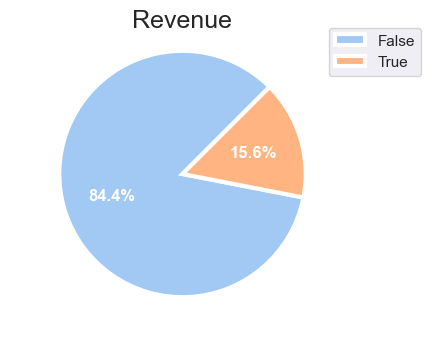

In [30]:
plt.figure(figsize=(7, 4))
data = [df['Revenue'].value_counts()[0], df['Revenue'].value_counts()[1]]
labels = ['False', 'True']
plt.pie(
    data, labels=labels,
    colors=sns.color_palette('pastel'), autopct='%.1f%%',
    wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},
    textprops={'size': 'medium', 'color': 'white', 'fontweight': 'bold'},
    startangle=45
)
plt.legend(labels=labels, loc='upper right', bbox_to_anchor=(1.3, 1))
plt.title('Revenue', fontsize=18, y=.95);

**План эксперимента**

1 _ Обучение базовых моделей (**Gaussian Naïve Bayes**, **kNN**, **Logistic Regression**, **Random Forest**) с параметрами по умолчанию на подмножестве *числовых признаков*.

2 _ Подобор оптимальных гиперпараметров для моделей, используя только *числовые* признаки.

3 _ Сравнение моделей с лучшими подобранными гиперпараметрами и выбор оптимальной на основе анализа метрик качества.

4 _ Обучение и дополнительный подбор гиперпараметров для выбранной модели на полном наборе признаков, включая как *числовые*, так и *категориальные*.

5 _ Оценка и анализ полученной модели в Explainer Dashboard.



In [31]:
def metrics_report(model_name, y_true, y_pred):
  sensitivity = sensitivity_score(y_true, y_pred)
  specificity = specificity_score(y_true, y_pred)
  mcc = matthews_corrcoef(y_true, y_pred)
  gmean = geometric_mean_score(y_true, y_pred)

  scores = pd.DataFrame({
      'Sensitivity': sensitivity,
      'Specificity': specificity,
      'G Mean': gmean,
      'MCC': mcc
  }, index=[model_name])

  plt.show(splt.metrics.plot_confusion_matrix(y_true, y_pred))
  return scores

При оценке эффективности моделей на несбалансированных данных рассматривались следующие метрики:

- __*Sensitivity*__ (=*Recall*): мера эффективности классификатора на положительном (миноритарном) классе;

- __*Specificity*__: мера эффективности классификатора на отрицательном (преобладающем) классе;

- __*G-Mean*__: среднее геометрическое *Sensitivity* и *Specificity*; чем выше значение этой метрики, тем точнее классификация для каждого из классов, при условии сохранении баланса между ними;

- __*Matthew's Correlation Coefficient*__ (MCC): коэффициент корреляции между прогнозируемыми и фактическими значениями, который учитывает все значения из матрицы ошибок; принимает значения в диапазоне от -1 до +1.

Кроме того, проводилось сравнение моделей, обученных на числовых признаках, на основе __*ROC-кривых*__ и соответствующих показателей __*AUC*__.

## 1. Построение моделей на числовых признаках

### Подготовка данных

На данном этапе оставляем только *числовые* признаки.

Данные разбиваются на тренировочную (**75%**) и тестовую (**25%**) выборку.

In [32]:
X = df[numerical]
y = df['Revenue']

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=8)

In [34]:
scaler = RobustScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Naïve Bayes Classifier

In [35]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)

gnb_pred = gnb.predict(X_test)
gnb_probs = gnb.predict_proba(X_test)[:, 1]

GaussianNB()

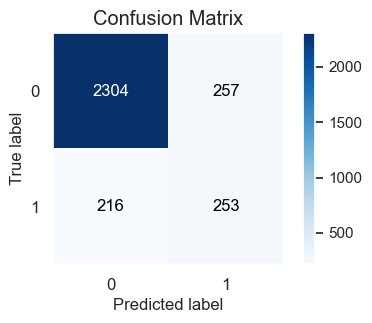

,Sensitivity,Specificity,G Mean,MCC
GNB,0.539446,0.899649,0.696643,0.424486


In [36]:
metrics_report('GNB', y_test, gnb_pred)

**Модель 1: GaussianNB**

Метрики G-Mean (0.6966) и MCC (0.4245) указывают на среднее качество классификатора Gaussian Naïve Bayes. Анализ матрицы ошибок показывает, что довольно низкие показатели агрегированных метрик получаются из-за недостаточной способности модели определять объекты положительного (миноритарного) класса.

GaussianNB с параметрами по умолчанию правильно классифицирует только 53.94% случаев, когда сессия пользователя завершается покупкой, и ошибочно относит объекты положительного класса к отрицательному в 46.06% случаев.

Модель эффективно справляется с классификацией доминирующего отрицательного класса: она дает 89.96% верных ответов и ошибается в 10.04% предсказаний.

Количество ложноположительных ответов превышает количество верно классифицированных объектов положительного класса, что может свидетельствовать о низкой способности модели различать классы между собой.

### KNN

In [37]:
knn_cl = KNeighborsClassifier()
knn_cl.fit(X_train_scaled, y_train)

knn_probs = knn_cl.predict_proba(X_test_scaled)[:, 1]
knn_pred = knn_cl.predict(X_test_scaled)

KNeighborsClassifier()

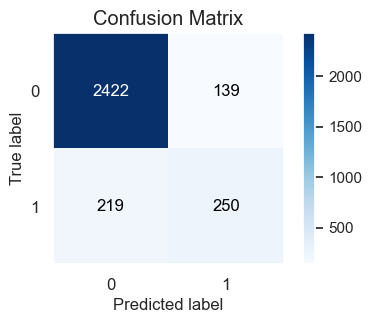

,Sensitivity,Specificity,G Mean,MCC
kNN,0.533049,0.945724,0.710012,0.517681


In [38]:
metrics_report('kNN', y_test, knn_pred)

**Модель 2: kNN**

По оценкам общей производительности базовая модель kNN показала лучшее качество по сравнению с GaussianNB: G Mean составил 0.71, а MCC — 0.5177.

Улучшение показателей интегральных метрик объясняется снижением числа ложноположительных ошибок. Модель kNN верно определяет 94.57% сессий, по завершении которых пользователь ничего не купит.

Однако по показателю Sensitivity, который отражает способность модели классифицировать объекты из менее представленного класса, kNN показывает результат хуже, чем GaussianNB, и ошибается в 46,7% ответов.

### Логистическая регрессия

In [39]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

lr_probs = lr.predict_proba(X_test)[:, 1]
lr_pred = lr.predict(X_test)

c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


LogisticRegression()

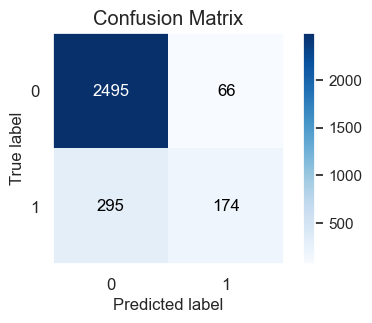

,Sensitivity,Specificity,G Mean,MCC
LR,0.371002,0.974229,0.6012,0.462374


In [40]:
metrics_report('LR', y_test, lr_pred)

**Модель 3: Логистическая регрессия**

По общим метрикам модель логистической регрессии показывает среднее качество в общем и по сравнению с предыдущими моделями: G Mean — 0.6012 и MCC — 0.4624.

Обобщенные метрики приближают логистическую регрессию к GaussianNB, при этом значение коэффициента корреляции Мэттьюса выше у логистической регрессии, а значение G Mean выше у GaussianNB.

Матрица ошибок показывает, что сумма ложноположительныхи ложноотрицательных ответов у логистической регрессии меньше, чем у GaussianNB (на 112 ошибок). Это достигается за счет того, что модель мало ошибавется на объектах преобладающего отрицательного класса модель (в 2.58% случаев), и в 97.42% случаев точно определяет, что покупки не будет. Уменьшение общего числа ошибок дает прирост по показателю MCC по сравнению с GaussianNB.

Однако модель логистической регрессии с параметрами по умолчанию не справляется с корректной классификацией объектов миноритарного (положительного) класса на сильно несбалансированных данных. Для большинства объектов положительного класса (68.9%) модель дает ошибочный ответ, а верно классифицирует только 37.1% объектов. Из-за низкого показателя Sensitivity, несмотря на увеличение Specificity, G Mean у логистической регрессии оказывается ниже, чем у GaussianNB.


### Random Forest

In [41]:
rf = RandomForestClassifier(random_state=8)
rf.fit(X_train, y_train)

rf_probs = rf.predict_proba(X_test)[:, 1]
rf_pred = rf.predict(X_test)

RandomForestClassifier(random_state=8)

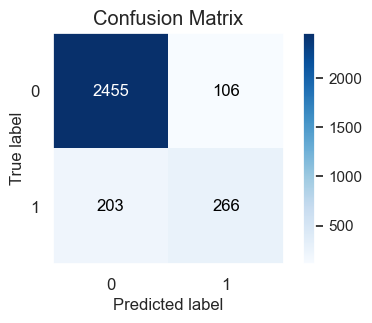

,Sensitivity,Specificity,G Mean,MCC
RF,0.567164,0.95861,0.737353,0.579484


In [42]:
metrics_report('RF', y_test, rf_pred)

**Модель 4: Random Forest**

Среди всех моделей в данном эксперименте Random Forest показывает лучшее качество по всем анализируемым на текущем этапе показателям, за исключением Specificity (у RF — 95.86%, а у LR — 97.42%).

Из проанализированных ранее моделей наиболее близкой к Random Forest является kNN. Значения метрик Random Forest превышают показатели классификатора kNN не более чем на 0.618 (разница по MCC). Модель Random Forest дает меньше как ложноположительных (на 33), так и ложноотрицательных ответов (на 16) по сравнению с kNN.

Random Forest достигает высокого качества (95.86%) при классификации объектов из преобладающего негативного класса. Эффективность классификатора на положительных примерах умеренная, но более половины положительных объектов (56.72%) была классифицирована правильно.

### Сравнение моделей

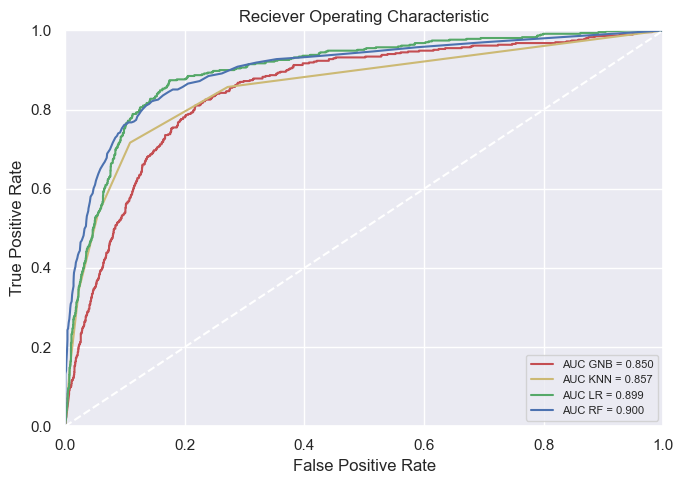

In [43]:
fpr_gnb, tpr_gnb, _ = roc_curve(y_test, gnb_probs)
roc_auc_gnb = auc(fpr_gnb, tpr_gnb)
fpr_knn, tpr_knn, _ = roc_curve(y_test, knn_probs)
roc_auc_knn = auc(fpr_knn, tpr_knn)
fpr_lr, tpr_lr, _ = roc_curve(y_test, lr_probs)
roc_auc_lr = auc(fpr_lr, tpr_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_probs)
roc_auc_rf = auc(fpr_rf, tpr_rf)

plt.figure(figsize=(7, 5))
plt.plot(fpr_gnb, tpr_gnb, 'r', label='AUC GNB = %0.3f' % roc_auc_gnb)
plt.plot(fpr_knn, tpr_knn, 'y', label='AUC KNN = %0.3f' % roc_auc_knn)
plt.plot(fpr_lr, tpr_lr, 'g', label='AUC LR = %0.3f' % roc_auc_lr)
plt.plot(fpr_rf, tpr_rf, 'b', label='AUC RF = %0.3f' % roc_auc_rf)
plt.plot([0,1], [0,1], 'w--')

plt.title('Reciever Operating Characteristic')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.tight_layout()
plt.legend(loc='lower right', prop={'size': 8});

По визуализации ROC-кривых для каждой из моделей можно сказать, что модели Random Forest и логистическая регрессия показывают в общем лучшую производительность. Кривые этих классификаторов пересекаются в нескольких местах, и по графикам нельзя однозначно определить лучшую модель. Однако количественное значение AUC указывает на небольшое преимущество модели Random Forest.

**Выводы по итогам обучения моделей на числовых признаках с параметрами по умолчанию:**


- На данном этапе модель **Random Forest** показала наиболее оптимальное соотношение верных и ошибочных ответов в двух классах и лучшие значения по интегральным метрикам.

- Сильный дисбаланс классов с преобладанием объектов отрицательного класса в обучающих данных заметно повлиял на производительность всех четырех моделей. Это отражается в низких значения метрики Sensitivity. Лучших результатов по данной метрике достигла модель **Random Forest** (56.72%).

- 3 из 4 базовых моделей смогли верно классифицировать более 50% объектов менее представленного в обучающей выборке положительного класса. Только модель **логистической регрессии** с параметрами по умолчанию в большинстве случаев (68.9%) классификации объектов положительного класса давала ошибочный ответ.

- 3 из 4 моделей с параметрами по умолчанию дали верные ответы на более чем 90% объектах преобладающего отрицательного класса. Самый низкий показатель по этой метрике — 89.96% — у классификатора **GaussianNB**, самый высокий — 97.42% — у модели **логистической регрессии**.

## 2. Подбор гиперпараметров

Для каждой из рассматриваемых моделей используется метод GridSearch для подбора гиперпараметров, максимизирующих метрику `roc_auc`.

### Naïve Bayes Classifier


Для модели GaussianNB настраивается гиперпараметр `var_smoothing`, который позволяет увеличить устойчивость к выбросам.

In [44]:
gnb_params = {
    'var_smoothing': np.logspace(-9, 0, num=100)
}

In [45]:
gs_gnb = GridSearchCV(gnb, gnb_params, scoring='roc_auc', cv=4, n_jobs=-1, verbose=2)
gs_gnb.fit(X_train, y_train)

Fitting 4 folds for each of 100 candidates, totalling 400 fits


GridSearchCV(cv=4, estimator=GaussianNB(), n_jobs=-1,
             param_grid={'var_smoothing': array([1.00000000e-09, 1.23284674e-09, 1.51991108e-09, 1.87381742e-09,
       2.31012970e-09, 2.84803587e-09, 3.51119173e-09, 4.32876128e-09,
       5.33669923e-09, 6.57933225e-09, 8.11130831e-09, 1.00000000e-08,
       1.23284674e-08, 1.51991108e-08, 1.87381742e-08, 2.31012970e-08,
       2.84803587e-08, 3.5111917...
       8.11130831e-03, 1.00000000e-02, 1.23284674e-02, 1.51991108e-02,
       1.87381742e-02, 2.31012970e-02, 2.84803587e-02, 3.51119173e-02,
       4.32876128e-02, 5.33669923e-02, 6.57933225e-02, 8.11130831e-02,
       1.00000000e-01, 1.23284674e-01, 1.51991108e-01, 1.87381742e-01,
       2.31012970e-01, 2.84803587e-01, 3.51119173e-01, 4.32876128e-01,
       5.33669923e-01, 6.57933225e-01, 8.11130831e-01, 1.00000000e+00])},
             scoring='roc_auc', verbose=2)

In [46]:
gs_gnb_probs = gs_gnb.best_estimator_.predict_proba(X_test)[:, 1]
gs_gnb_pred = gs_gnb.best_estimator_.predict(X_test)

print(f'best score train: {gs_gnb.best_score_}')
print(f'best score test: {roc_auc_score(y_test, gs_gnb_pred)}\n')
print(f'parameters:\n{gs_gnb.best_params_}')

best score train: 0.8502132165229714
best score test: 0.6974466930145391

parameters:
{'var_smoothing': 2.310129700083158e-06}


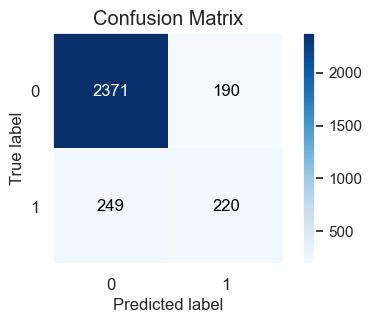

,Sensitivity,Specificity,G Mean,MCC
GS GNB,0.469083,0.92581,0.659001,0.417569


In [47]:
metrics_report('GS GNB', y_test, gs_gnb_pred)

**По сравнению с базовой моделью GaussianNB:**

После подбора гиперпарметров снижается качество по обобщенным мерам G Mean (-0.0376) и MCC (-0.0069).

Ухудшение общего качества обусловлено тем, что после настройки гиперпараметров модель GaussianNB чаще ошибавется на объектах миноритарного положительного класса (снижение на 7.06% по показателю Sensitivity). В то же время значение показателя Specificity увеличилось на 2.62%.

Количество ложноположительных ответов сократилось. Но количество ложноотрицательных ответов увеличилось и стало превышать число правильно классифицированных объектов положительного класса.

### KNN

Для модели kNN настраиваются гиперпараметры:

- `n_neighbors`: количество учитываемых при классификации ближайших соседей;
- `weights`: веса соседей (одинаковые для всех соседей или пропорциональные расстоянию до классифицируемого объекта);
- `metric`: метрика расстояния для определения близости соседей.

In [48]:
knn_params = {
    'n_neighbors': np.arange(2, 20, 2),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

In [49]:
gs_knn = GridSearchCV(knn_cl, knn_params, scoring='roc_auc', cv=4, n_jobs=-1, verbose=2)
gs_knn.fit(X_train_scaled, y_train)

Fitting 4 folds for each of 36 candidates, totalling 144 fits


GridSearchCV(cv=4, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                         'weights': ['uniform', 'distance']},
             scoring='roc_auc', verbose=2)

In [50]:
gs_knn_probs = gs_knn.best_estimator_.predict_proba(X_test_scaled)[:, 1]
gs_knn_pred = gs_knn.best_estimator_.predict(X_test_scaled)

print(f'best score train: {gs_knn.best_score_}')
print(f'best score test: {roc_auc_score(y_test, gs_knn_pred)}\n')
print(f'parameters:\n{gs_knn.best_params_}')

best score train: 0.8853840426091264
best score test: 0.7452129656842136

parameters:
{'metric': 'manhattan', 'n_neighbors': 18, 'weights': 'distance'}


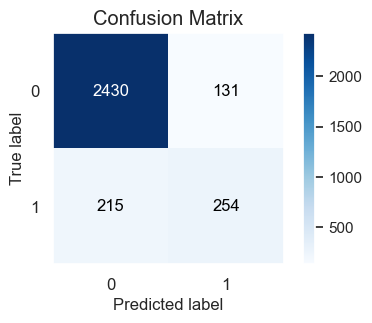

,Sensitivity,Specificity,G Mean,MCC
GS kNN,0.541578,0.948848,0.716851,0.532625


In [51]:
metrics_report('GS kNN', y_test, gs_knn_pred)

**По сравнению с базовой моделью kNN:**

После настройки гиперпараметров качество модели kNN увеличивается как на положительном, так и на отрицательном классах: Sensitivity +0.86%, Specificity +0.31%.

Следовательно, заметен небольшой прирост качества по общим мерам: G Mean +0.0069, MCC +0.0149.

### Логистическая регрессия


Для модели логистической регрессии настраиваются гиперпараметры:

- `class_weight` для присваивания разных весов в зависимости от класса;
- `C` для контроля силы регуляризации;
- `solver` для выбора лучшего алгоритма оптимизации;
- `max_iter` для контроля числа операций.

In [52]:
lr_params = {
    'class_weight': [None, 'balanced'],
    'C': np.logspace(-3, 3, 7),
    'solver': ['newton-cg', 'sag', 'saga', 'liblinear'],
    'max_iter': [30, 50, 100]
}

In [53]:
gs_lr = GridSearchCV(LogisticRegression(class_weight={0: 0.6, 1: 3}), lr_params, scoring='roc_auc', cv=4, n_jobs=-1, verbose=2)
gs_lr.fit(X_train, y_train)

Fitting 4 folds for each of 168 candidates, totalling 672 fits


GridSearchCV(cv=4, estimator=LogisticRegression(class_weight={0: 0.6, 1: 3}),
             n_jobs=-1,
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'class_weight': [None, 'balanced'],
                         'max_iter': [30, 50, 100],
                         'solver': ['newton-cg', 'sag', 'saga', 'liblinear']},
             scoring='roc_auc', verbose=2)

In [54]:
gs_lr_probs = gs_lr.best_estimator_.predict_proba(X_test)[:, 1]
gs_lr_pred = gs_lr.best_estimator_.predict(X_test)

print(f'best score train: {gs_lr.best_score_}')
print(f'best score test: {roc_auc_score(y_test, gs_lr_pred)}\n')
print(f'parameters:\n{gs_lr.best_params_}')

best score train: 0.8885536748609657
best score test: 0.833573389259426

parameters:
{'C': 0.01, 'class_weight': 'balanced', 'max_iter': 30, 'solver': 'liblinear'}


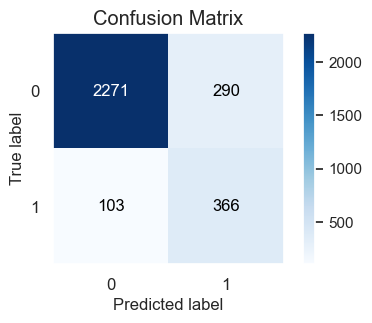

,Sensitivity,Specificity,G Mean,MCC
GS LR,0.780384,0.886763,0.831875,0.585896


In [55]:
metrics_report('GS LR', y_test, gs_lr_pred)

**По сравнению с базовой моделью Logistic Regression:**

Настройка гиперпараметров модели логистической регресии позволила увеличить производительность модели по обобщенным мерам: G Mean +0.2307 и MCC +0.1235.

Это достигается за счет того, что после подбора гиперпараметров модель стала более эффективно классифицировать объекты миноритарного положительного класса, верно определяя 78.04% случаев (прирост на 40.94% по сравнению с базовой моделью). По метрике Specificity, который характеризует эффективность классификации преобладающего отрицательного класса, наоборот наблюдается снижение на 8.74%, но значение показателя по-прежнему высокое — 88.67%.

### Random Forest

Для модели Random Forest настраиваются гиперпараметры:

- `n_estimators`: количество решающих деревьев в модели;
- `criterion`: критерий разделения узлов;
- `max_features`: максимальное количество признаков, участвующих в поиске лучшего разделения;
- `max_depth`: максимальная глубина деревьев;
- `class_weight`: веса классов.


In [56]:
rf_params = {
    'n_estimators': [300, 400, 500],
    'criterion': ['gini', 'entropy'],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [5, 10, 15],
    'class_weight': ['balanced', 'balanced_subsample']
}

In [57]:
gs_rf = GridSearchCV(rf, rf_params, scoring='roc_auc', cv=4, n_jobs=-1, verbose=2)
gs_rf.fit(X_train, y_train)

Fitting 4 folds for each of 72 candidates, totalling 288 fits


GridSearchCV(cv=4, estimator=RandomForestClassifier(random_state=8), n_jobs=-1,
             param_grid={'class_weight': ['balanced', 'balanced_subsample'],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 10, 15],
                         'max_features': ['sqrt', 'log2'],
                         'n_estimators': [300, 400, 500]},
             scoring='roc_auc', verbose=2)

In [58]:
gs_rf_probs = gs_rf.best_estimator_.predict_proba(X_test)[:, 1]
gs_rf_pred = gs_rf.best_estimator_.predict(X_test)

print(f'best score train: {gs_rf.best_score_}')
print(f'best score test: {roc_auc_score(y_test, gs_rf_pred)}\n')
print(f'parameters:\n{gs_rf.best_params_}')

best score train: 0.9056284311532967
best score test: 0.8502404860841105

parameters:
{'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 300}


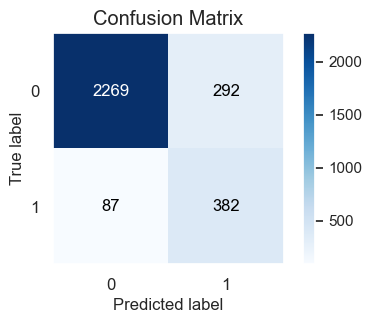

,Sensitivity,Specificity,G Mean,MCC
GS RF,0.814499,0.885982,0.849489,0.609214


In [59]:
metrics_report('GS RF', y_test, gs_rf_pred)

**По сравнению с базовой моделью Random Forest:**

Подбор гиперпараметров модели Random Forest привел к улучшению показателей обобщенных метрик: G Mean +0.1121 и MCC +0.0297.

Значительно уменьшилось количество ложноотрицательных ответов. Оптимизированная модель верно классифицирует 81.45% объектов меньшего положительного класса (прирост на 24.73% по метрике Sensitivity). При этом доля верных ответов на объектах прреобладающего отрицательного класса снизилась. Random Forest с подобранными гиперпараметрами точно определяет 88.6% объектов из отрицательного класса (снижение на 7.26%).

In [60]:
# joblib.dump(gs_rf.best_estimator_, 'rf-models/best_random_forest.pkl')

### Сравнение моделей

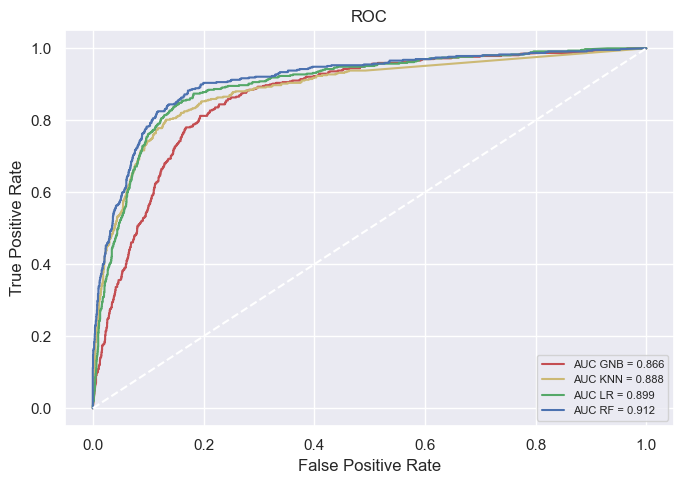

In [61]:
fpr_gnb, tpr_gnb, _ = roc_curve(y_test, gs_gnb_probs)
roc_auc_gnb = auc(fpr_gnb, tpr_gnb)
fpr_knn, tpr_knn, _ = roc_curve(y_test, gs_knn_probs)
roc_auc_knn = auc(fpr_knn, tpr_knn)
fpr_lr, tpr_lr, _ = roc_curve(y_test, gs_lr_probs)
roc_auc_lr = auc(fpr_lr, tpr_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_test, gs_rf_probs)
roc_auc_rf = auc(fpr_rf, tpr_rf)

plt.figure(figsize=(7, 5))
plt.plot(fpr_gnb, tpr_gnb, 'r', label='AUC GNB = %0.3f' % roc_auc_gnb)
plt.plot(fpr_knn, tpr_knn, 'y', label='AUC KNN = %0.3f' % roc_auc_knn)
plt.plot(fpr_lr, tpr_lr, 'g', label='AUC LR = %0.3f' % roc_auc_lr)
plt.plot(fpr_rf, tpr_rf, 'b', label='AUC RF = %0.3f' % roc_auc_rf)
plt.plot([0,1], [0,1], 'w--')

plt.title('ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.tight_layout()
plt.legend(loc='lower right', prop={'size': 8});

По показателям AUC 3 из 4 моделей демонстррируют небольшое улучшение: GaussianNB +0.016, kNN +0.031, Random Forest +0.012. Значение AUC логистической регрессии не изменилось, несмотря на то, что анализ метрик по отдельным аспектам производительности модели показал, что после подбора гиперпараметров модель стала менее предвзятой в сторону преобладающего класса и ее предсказания стали более сбалансированними.

По метрикам AUC и по графикам ROC-кривых видно, что модель Random Forest в целом превосходит остальные модели в решении задачи классификации на данных с сильным дисбалансом.

**Выводы по итогам обучения моделей на числовых признаках с подбором гиперпараметров:**

- Настройка гиперпараметров классификатора **GaussianNB** привела к отклонениям в производительности модели в сторону преобладающего класса, снижению эффективности на менее представленном классе и уменьшению качества по общим показателям.

- Донастроенная модель **kNN** показала одинаково незначительное улучшение по всем анализируемым показателям качества. Степень предвзятости классификатора в сторону отрицательного класса не изменилась.

- В результате подбора гиперпараметров для моделей **логистической регрессии** и **Random Forest** увеличилась степень сбалансированности предсказаний обоих классификаторов на двух классах. Это выражается в значительном улучшении эффективности классификации на объектах меньшего положительного класса, и снижении качества на преобладающем отрицательном классе, которое тем не менее отстается высоким (более 88%) у обеих моделей.


Для дальнейших экспериментов была выбрана модель **Random Forest**. Несмотря на значительный прогресс модели логистической регрессии, Random Forest демонстрирует лучшие показатели по всем метрикам, кроме Specificity, по которой у логистической регрессии небольшое преимущество в 0.08%. Кроме того, Random Forest обеспечивает более сбалансированный результат в классификации преобладающего и миноритарного классов.

## 3. Учет категориальных признаков

Обучение модели Random Forest с лучшими по GridSearch гиперпараметрами на *числовых* и *категориальных* признаках. Дополнительный подбор гиперпарапметров на полном наборе признаков.

In [62]:
# best_rf = joblib.load('rf-models/best_random_forest.pkl')

best_rf = gs_rf.best_estimator_

### Добавление категориальных признаков в данные

Категориальные признаки преобразуются с помощью метода One-Hot Encoding.

In [63]:
X_full = df.drop('Revenue', axis=1)

X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X_full, y, test_size=0.25, random_state=8)

In [64]:
ct = ColumnTransformer([('ohe', OneHotEncoder(handle_unknown='ignore'), categorical)], remainder='passthrough')

X_train_transformed = ct.fit_transform(X_train_full)
X_test_transformed = ct.transform(X_test_full)

new_features = list(ct.named_transformers_['ohe'].get_feature_names_out(input_features=categorical))
new_features.extend(numerical)

X_train_transformed = pd.DataFrame.sparse.from_spmatrix(X_train_transformed, columns=new_features)
X_test_transformed = pd.DataFrame.sparse.from_spmatrix(X_test_transformed, columns=new_features)

### Обучение модели на полном наборе признаков

In [65]:
best_rf.fit(X_train_transformed, y_train_full)

RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       max_depth=5, n_estimators=300, random_state=8)

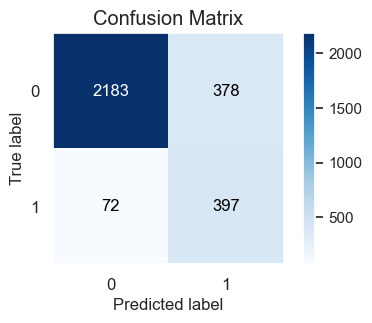

,Sensitivity,Specificity,G Mean,MCC
Best RF,0.846482,0.852401,0.849436,0.579391


In [66]:
full_pred = best_rf.predict(X_test_transformed)

metrics_report('Best RF', y_test_full, full_pred)

**По сравнению с моделью, обученной только на числовых признаках:**

После добавления категориальных признаков общая производительность модели незначительно снизились: G Mean -0.0001 и MCC -0.0096.

Увеличилось качество классификации модели на объектах миноритарного положительного класса (+3.2%). Эффективность модели в предсказании преобладающего отрицательного класса снизилась (-3.36%).

После включения категориальных признаков в модель Random Forest, значения эффективности прогнозирования для обоих классов стали ближе друг к другу. Качество модели, обученной на полном наборе признаков, по метрике Specificity (точность на преобладающем классе) превосходит значение по Sensitivity (точность на меньшем классе) всего на 0.59%. В то время как для модели, обученной только на числовых признаках, разница между Specificity и Sensitivity составляла 7.15%.

Отмечается увеличение ложноположительных ответов, число которых приближается к числу истинно положительных объектов, а также снижение количества ложноотрицательных ответов.

### Подбор гиперпараметров

In [67]:
rf_params_full = {
    'n_estimators': [300, 400, 500],
    'criterion': ['gini', 'entropy'],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [3, 5, 10, 15],
    'class_weight': ['balanced', 'balanced_subsample']
}

In [68]:
gs_full = GridSearchCV(best_rf, rf_params, scoring='roc_auc', cv=4, n_jobs=-1, verbose=2)
gs_full.fit(X_train_transformed, y_train_full)

Fitting 4 folds for each of 72 candidates, totalling 288 fits


GridSearchCV(cv=4,
             estimator=RandomForestClassifier(class_weight='balanced_subsample',
                                              criterion='entropy', max_depth=5,
                                              n_estimators=300,
                                              random_state=8),
             n_jobs=-1,
             param_grid={'class_weight': ['balanced', 'balanced_subsample'],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 10, 15],
                         'max_features': ['sqrt', 'log2'],
                         'n_estimators': [300, 400, 500]},
             scoring='roc_auc', verbose=2)

In [69]:
gs_full_pred = gs_full.best_estimator_.predict(X_test_transformed)

print(f'roc_auc train: {gs_full.best_score_}')
print(f'roc_auc test: {roc_auc_score(y_test, gs_full_pred)}\n')
print(f'parameters:\n{gs_full.best_params_}')

roc_auc train: 0.921853171254192
roc_auc test: 0.8262493245825316

parameters:
{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 15, 'max_features': 'sqrt', 'n_estimators': 500}


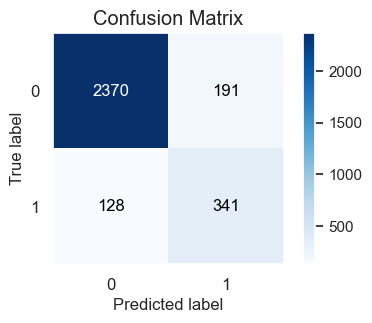

,Sensitivity,Specificity,G Mean,MCC
GS Best RF,0.727079,0.92542,0.820276,0.620324


In [70]:
metrics_report('GS Best RF', y_test_full, gs_full_pred)

****По сравнению с моделью, обученной на полном наборе признаков без повторного побдора гиперпараметров:****

После повторного подбора гиперпараметров для модели Random Forest на полном наборе признаков:
- значение G Mean уменьшилось (-0.0304);
- значение MCC увеличилось (+0.0394).

Эти изменения в пооказателях общей производительности обусловлены следующими факторами:

- Улучшение качества классификации объектов преобладающего класса (Specificity +7.3%) сопровождается более существенным снижением качества предсказания менее представленного классе (Sensitivity -12.16%). Это приводит к снижению показателя G Mean.

- Соотношение ложноположительных и истинно верных ответов кажется более оптимальным. Из всех объектов, которые донастроенная модель определила как положительные, 64.03% действительно являются положительными (для модели без донастройки гиперпараметров этот показатель равен 51.23%). Кроме того, донастроенная модель в сумме делает меньше ошибок при классификации. Поэтому отмечается увеличение значение MCC.

**Выводы по итогам обучения модели Random Forest на полном наборе признаков и с дополнительным подбором гиперпараметров:**

В целом эффект добавления категориальных признаков и дополнительного подбора гиперпараметров модели Random Forest кажется скорее положительным за счет сбалансированного уменьшения как ложноположительных, так и ложноотрицательных ответов. Хотя увеличивается предвзятость модели в сторону преобладающего отрицательного класса, что проявляется в увеличении Specificity и уменьшении Sensitivity, качество классификации объектов менее представленного в данных положительного класса остается достаточно высоким (72.49%). Эффективность определения объектов отрицательного класса составляет 92.54%. Доля ложно положительных ответов — 7.46%, доля ложноотрицательных ответов — 27.5%

Итоговая оценка успешности модели будет зависеть от бизнес-требований и стоимости разного рода ошибок. В дальнейшем, возможно, следует провести отбор признаков для обучения и/или создать новые более значимые признаки.

In [71]:
# joblib.dump(gs_full.best_estimator_, 'rf-models/best_full_random_forest.pkl')

## Explainer Dashboard

### Построение Explainer Dashboard

In [72]:
# model = joblib.load('rf-models/best_full_random_forest.pkl')

model = gs_full.best_estimator_
X_test_transformed.columns = new_features

In [ ]:
explainer = ClassifierExplainer(model, X_test_transformed, y_test_full, labels=['No Purchase', 'Purchase'])
db = ExplainerDashboard(explainer, title='Online Shoppers Purchasing Intention Prediction', whatif=False, shap_interaction=False)
db.to_yaml('dashboard.yaml', explainerfile='explainer.joblib', dump_explainer=True)

db.run()

<a id='my-section'></a>
### Анализ Explainer Dashboard

**1 _ Наиболее важные для получения прогноза факторы**

![Shap Plot](https://raw.githubusercontent.com/ErmakovaAna/shoppers-intention-prediction/main/model/plots/shap.png)

В топ-20 признаков, которые в среднем больше всего влияют на предсказание модели, попадают все числовые признаки и некоторые категориальные признаки. Из **категориальных признаков** для модели были важны следующие факторы:
- месяц посещения сайта магазина: самые показательные месяцы — Ноябрь, Март, Май, Декабрь;
- тип трафика, то есть по каким каналам пользователь попадает на сайт;
- является ли пользователь новым покупателем или нет;
- технические аспекты устройства, через котороое пользователь взаимодействует с сайтом.

Из **числовых признаков** самое большое влияние на решение модели оказывает признак PageValues, то есть средняя ценность посещенных пользователем страниц. В среднем этот признак изменяет предсказанную вероятность того, что пользователь совершит покупку, более чем на 20%.

Также важны такие показатели, как:
- средние показатели выходов и отказов по страницам;
- количество и продолжительность посещения страниц, при этом большее влияние оказывает посещение страниц, связанных с продуктом, и административных страниц, а взаимодействия с информационными страницами менее важны; 
- близость времени совершения сессии к праздничным дням SpecialDay (однако этот признак изменяет вероятность менее чем на 1%).

**2 _ Значения метрик**

| Metric          | Score   |
|-----------------|---------|
| Accuracy        | 0.895   | 
| Precision       | 0.641   |
| Recall          | 0.727   |
| F1 Score        | 0.681   |
| ROC AUC Score   | 0.928   |
| PR AUC Score    | 0.735   |
| Log Loss        | 0.269   |

Значения метрик при стандартном пороге 0.5 свидетельствуют о том, что модель показывает средюю производительность (около 68% по **F1**) и имеет небольшое отклонение предсказанных вероятностей от фактических значений классов (**Log Loss** — 0.269)

Несмотря на сильный дисбаланс классов, модель показывает относительно сбалансированные (но не очень высокие) значения точности и полноты. Умеренный баланс между точностью и полнотой подтверждается значением **PR AUC Score**, которое составляет 73.5%.

Классификатор делает больше ложноположительных предсказаний, чем ложноотрицательных. Из всех посещений сайта, во время которых была совершена покупка, модель смогла верно определить около 73% случаев (по **Recall**). И примерно в 64% случаев (**Precision**), когда модель предсказывала, что будет совершена покупка, пользователь сайта действительно что-то покупал. Высокий **ROC AUC Score** (около 93%) указывает на то, что модель достигает хорошего компромисса между ошибками разного рода.

Значение **Accuracy**, говорит о том, что истнно положительные и истинно отрицательные ответы классификатора в сумме составляют 89.5% относительно всего набора тестовых данных.


**3 _ Анализ индивидуальных прогнозов**
*(Contribution Plot Depth = 8)*

**Объект 2824**: истинный класс __*положительный*__, предсказанный класс __*положительный*__

| Label         | Probability |
|---------------|-------------|
| No Purchase   | 17.3 %      |
| Purchase*     | 82.7 %      |

![2824](https://raw.githubusercontent.com/ErmakovaAna/shoppers-intention-prediction/main/model/plots/2824.png)

Модель верно определила, что сессия завершилась совершением покупки. Наибольший вклад в решение внес признак средней ценности посещенных страниц PageValues, значение которого на данном объекте сильно превосходит среднее значение по данным. Также значимый положительный вклад внесли нулевые показатели отказов и выходов со страниц. Отрицательное влияние оказали факты выполнение сессии из региона 5, на операционной системе 4 и не в ноябре.

**Объект 63**: истинный класс __*положительный*__, предсказанный класс __*отрицательный*__

| Label        | Probability   |
|--------------|---------------|
| No Purchase  | 63.0 %        |
| Purchase*    | 37.0 %        |

![63](https://raw.githubusercontent.com/ErmakovaAna/shoppers-intention-prediction/main/model/plots/63.png)

Модель показала, что во время сессии с 63% вероятностью покупки не будет, что является неверным предсказанием. На 37% вероятности, что объект относится к положительному классу, повлияло то, что сессия выполнялась в ноябре, и то, что не в мае, низкий показатель выходов, а также время, проведенное пользователем на Product Related страницах, которое превысило средние показатели примерно в 2 раза. Однако итоговая классификация была ошибочной, поскольку нулевой показатель ценности страниц оказывает сильное отрицательное влияние. Отрицательный вклад вносят также тип трафика 1 и то, что пользователь во время сессии не посещал административные страницы.

**Объект 1351**: истинный класс __*отрицательный*__, предсказанный класс __*положительный*__

|   Label        | Probability   |
| --------------- | ------------- |
| No Purchase*   | 23.4 %        |
| Purchase       | 76.6 %        |

![1351](https://raw.githubusercontent.com/ErmakovaAna/shoppers-intention-prediction/main/model/plots/1351.png)

Модель делает неверную классификацию, показывая, что во время сессии с вероятностью 76.6% пользователь совершит покупку, но на самом деле покупки не было. На решение модели сильно влияет высокий показатель ценности страниц PageValues, примерно в 5 раз превышающий среднее значение. Кроме того положительный вклад вносят низкий показатель выходов, время проведенное пользователем на Product Related страницах, превысившее медианное значение по данным, а также трафик типа 2. Отрицательные вклад вносят показатель отказов, более чем в 4 раза превышающий медианное значение, то, что сессия выполнялась не в ноябре, то, что пользователь относится к категории Returning Visitor и что он не посетил административные страницы сайта.

**Общие выводы по анализу индивидуальных прогнозов**

- Значение показателя PageValues кажется слишком большим по сравнению с влиянием всех остальных признаков, что может привести к возникновению как ошибок первого, так и второго рода. При этом данный показатель предоставляет информацию о посещаемых страницах на основе данных о предыдущих сессиях и не имеет непосредственной связи с текущей сессией.  

- Вклад числовых признаков в итоговый ответ понятен и интерпретуруем, поскольку значения эти признаков на конкретном объекте можно сравнить со средним и медианным значением по всем данным. В то же время, чтобы объяснить влияние категориальных признаков (например, факт, что сессия выполнялась в ноябре, вносит положительный вклад, а если был декабрь — отрицательный, или влияние операционной системы пользователя на конверсию) нужно дополнительное исследование.